In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from src.utils.plot import plot_normalized_positions
from src.utils.paths import paths_no_backtrack
from src.utils.probs import posterior_probabilites, entropies_prior_posterior, information_gain
from src.utils.distances import compute_distances
from src.utils.load_data import load_data

## 1. Data loading and pre-processing

In [6]:
articles, categories, links, paths_finished_humans, paths_finished_llm, paths_unfinished, paths_unfinished_llm_df = load_data()

### Handling Missing Values

We found missing values for the rating of finished paths and decided not to impute them as replacing missing values with the median rating would not make sense. We will only use finished paths with a human rating and discard all other finished paths when we need to make analysis based on the rating.

### Handling the data size

Our pipeline can handle the datasize as we do not need to handle bigger datasets than the ones we have already treated through this pipeline.

### Analyzing path lengths

We see that the LLM has a low median and mean path length, **but** the here we only consider the LLM paths that finished, and about 50% of the LLM paths failed, so this does not mean much yet.

TODO Analyze again once we have the paths of LLM with memory

In [7]:
# Computing descriptive statistics human and LLM finished paths lengths

paths_finished_len_humans = paths_finished_humans['path'].apply(len)
paths_finished_len_llm = paths_finished_llm.apply(len)
print(paths_finished_len_humans.describe())
print(paths_finished_len_llm.describe())

count    51307.000000
mean         6.758668
std          4.680461
min          2.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path, dtype: float64
count    13910.000000
mean         4.654062
std          1.606599
min          2.000000
25%          4.000000
50%          4.000000
75%          6.000000
max         17.000000
Name: path, dtype: float64


In [8]:
# Analyze the ratings given by humans
print(paths_finished_humans['rating'].describe())

count    28501.000000
mean         2.269780
std          1.110439
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rating, dtype: float64


### Exploring correlations

Here we evaluate the correlation between the difficulty and the path length for human games. 
We observe that the rating is positively correlated with the path length.
R2 shows that our model explains some of the variance of the data.
p is close to 0 which shows that the rating is a good predictor for the path length.

In [9]:
paths_finished_humans['path_length'] = paths_finished_len_humans
mod = smf.ols(formula='path_length ~ rating', data=paths_finished_humans)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            path_length   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     5551.
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:09:47   Log-Likelihood:                -84559.
No. Observations:               28501   AIC:                         1.691e+05
Df Residuals:                   28499   BIC:                         1.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4686      0.063     38.950      0.000       2.344       2.593
rating         1.8687      0.025     74.502      0.000       1.819       1.918
==============================================================================
Omnibus:                    73824.614   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6510845304.372
Skew:                          29.186   Prob(JB):                         0.00
Kurtosis:                    2343.773   Cond. No.                         6.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Compute probabilities and entropies

### 2.A. Prior click probability

![Formula for the prior click probability](./images/probs_prior.png)

The prior click probability only depends on the number of outlinks of each article.

In [10]:
# Count the out-links of each article to get the probability of clicking on any of them
out_degree = links.groupby('linkSource').size()
probs_prior = 1 / out_degree
# Create a Series indexed by 'linkSource' that gives a list of all the source’s out-links
out_links = links.groupby('linkSource')['linkTarget'].agg(list)

### 2.B. Posterior click probability

![Formula for the posterior click probability](./images/probs_posterior.png)

In [11]:
paths_finished = paths_no_backtrack(paths_finished_humans['path'])
probs_posterior_humans = posterior_probabilites(paths_finished, out_links, out_degree)
probs_posterior_llm = posterior_probabilites(paths_finished_llm, out_links, out_degree)

### 2.C. Prior and posterior entropies

Compute the prior and posterior entropy at each article along the path, except for the goal, because entropy is 0 once we have reached the goal.

In [12]:
entropies_prior_humans, entropies_posterior_humans = entropies_prior_posterior(paths_finished, probs_prior, probs_posterior_humans, out_degree)
# TODO: entropies_prior_llm is redundant with entropies_prior_human because they’re the same
entropies_prior_llm, entropies_posterior_llm = entropies_prior_posterior(paths_finished_llm, probs_prior, probs_posterior_llm, out_degree)

## 3. Split the paths

### 3.A. Compute “information gain”

This represents how much information we gain by looking at the click distribution, as described in section 4 and figure 2 of the paper.

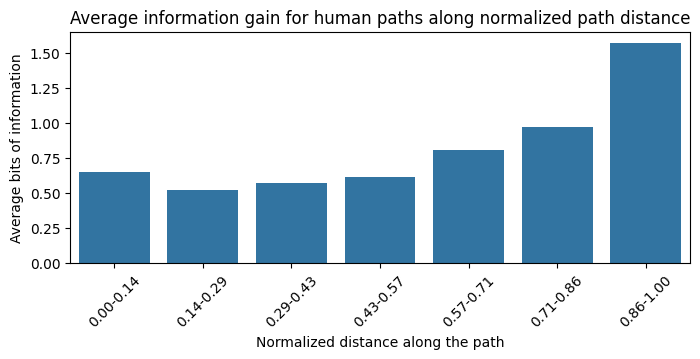

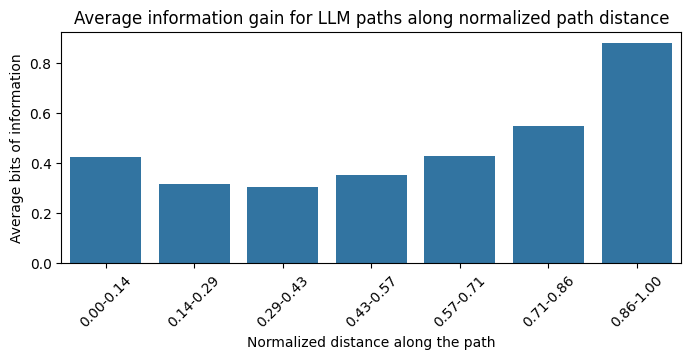

In [13]:
# Compute and plot the information gain for human and for LLM paths
info_gain_humans = information_gain(entropies_prior_humans, entropies_posterior_humans)
info_gain_llm = information_gain(entropies_prior_llm, entropies_posterior_llm)
plot_normalized_positions(info_gain_humans, 'information gain for human paths')
plot_normalized_positions(info_gain_llm, 'information gain for LLM paths')

This is similar to what the paper gets:

![information gain graph from the paper](./images/fig_2_paper.png)

We can see that the LLM seems to exhibit the same strategy of “getting away” from the starting article to a more general/generic “hub” article, and then “homing in” on the target article by getting more and more specific.

TODO: we need a statistical test to verify that rigorously. This graph only shows **average** information gain along **normalized** path length.

### 3.B. Get the splitting point and split the paths

In [14]:
# Get the index of the point of lowest information gain for each path
argmin_info_gain_humans = info_gain_humans.apply(np.argmin)
argmin_info_gain_llm = info_gain_llm.apply(np.argmin)
# Split the path at this point and keep only the second part, corresponding to the “homing in” phase
paths_homing_in_humans = pd.Series([path[argmin_info_gain_humans[i]:] for i, path in paths_finished.items()])
paths_homing_in_llm = pd.Series([path[argmin_info_gain_llm[i]:] for i, path in paths_finished_llm.items()])

## 4. Compute embedding distances

We now need to get a list of all the article titles whose embedding we need to compute, as well as the list of pairs of articles between which we need to compute the distance.

In [15]:
# Compute the set of all articles encountered in the paths_homing_in_humans
# Every article encountered along a goal has a defined distance with the goal
all_distance_pairs = set()
all_articles = set()
for path in paths_homing_in_humans:
    goal  = path[-1]
    for article in path:
        all_articles.add(article)
        all_distance_pairs.add((goal, article))

We use the sentence-transformers library to load the pre-trained BERT model and compute embeddings for each of our article titles. Then, we compute distances between these embeddings models, using both cosine similarity and Euclidean distance, which we return in a dataframe `similarities`.

In [16]:
from src.scripts.generate_embeddings_distances import get_embeddings_distances
distance_embeddings = get_embeddings_distances(all_articles, all_distance_pairs, 'data/article_similarities.csv')

## 5. Compute and analyze distances

In [73]:
distances_humans = compute_distances(links, probs_posterior_humans, paths_homing_in_humans, 'data/distances_humans.pkl')
distances_llm = compute_distances(links, probs_posterior_llm, paths_finished_llm, 'data/distances_llm.pkl')

In [74]:
series_distances_humans = pd.Series(distances_humans)
series_distances_llm = pd.Series(distances_llm)
intersection_index = series_distances_humans.index.intersection(series_distances_llm.index)
distances_human_llm = pd.DataFrame({ 'humans': series_distances_humans, 'llm': series_distances_llm}, index=intersection_index)

In [75]:
distances_human_llm['humans'].describe()

count    15866.000000
mean         0.384870
std          0.472799
min          0.000844
25%          0.176986
50%          0.316225
75%          0.498339
max         37.811398
Name: humans, dtype: float64

In [76]:
distances_human_llm['llm'].describe()

count    15866.000000
mean         0.403347
std          0.268385
min          0.006247
25%          0.211733
50%          0.350472
75%          0.529106
max          3.494916
Name: llm, dtype: float64

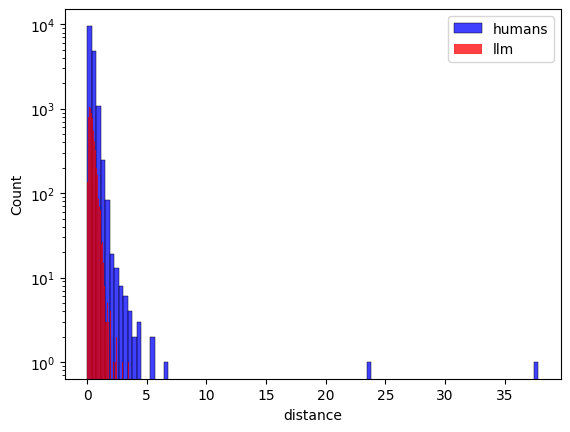

In [77]:
sns.histplot(distances_human_llm['humans'][intersection_index], bins=100, color='blue', label='humans')
sns.histplot(distances_human_llm['llm'][intersection_index], bins=100, color='red', label='llm')
plt.legend()
plt.xlabel('distance')
plt.yscale('log')

In [80]:
distance_differences_humans_llm = pd.Series(series_distances_humans - series_distances_llm, index=intersection_index)

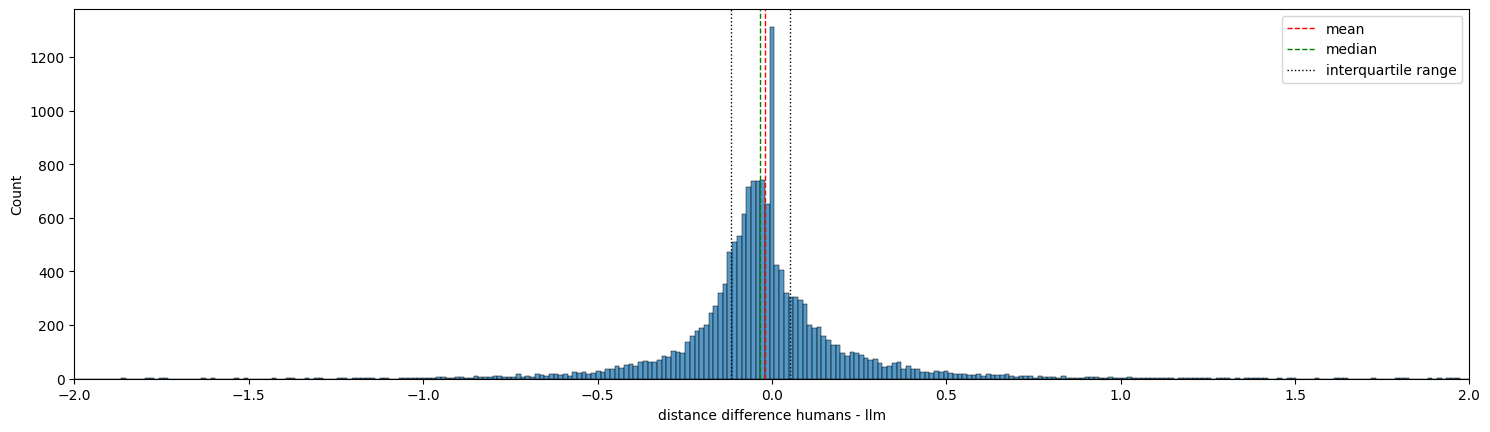

In [114]:
plt.figure().set_figwidth(18)
plt.xlim(-2,2)
sns.histplot(distance_differences_humans_llm)
plt.xlabel('distance difference humans - llm')
# make the mean, median visible
plt.axvline(distance_differences_humans_llm.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(distance_differences_humans_llm.median(), color='green', linestyle='dashed', linewidth=1)
# show the 25th and 75th percentile
plt.axvline(distance_differences_humans_llm.quantile(0.25), color='black', linestyle='dotted', linewidth=1)
plt.axvline(distance_differences_humans_llm.quantile(0.75), color='black', linestyle='dotted', linewidth=1)
plt.legend(['mean', 'median', 'interquartile range'])

In [93]:
distance_differences_humans_llm.describe()

count    15866.000000
mean        -0.018477
std          0.450774
min         -3.091321
25%         -0.117988
50%         -0.033702
75%          0.051277
max         37.486572
dtype: float64

In [94]:
# Print the 10 pairs with the highest difference
distance_differences_humans_llm.nsmallest(10)

6th_century  20th_century      -3.091321
             Rainforest        -3.091321
             19th_century      -2.781373
1st_century  16th_century      -2.751327
Radio        Ship              -2.353619
Israel       Great_Cormorant   -2.267989
Hydrogen     World_War_II      -1.863525
Gypsum       Italy             -1.795714
6th_century  17th_century      -1.783421
             18th_century      -1.783421
dtype: float64

In [95]:
distance_differences_humans_llm.nlargest(10)

English_language  Dutch_language    37.486572
                  Thomas_Hobbes     23.476005
Canada            Japan              6.234154
Force             Cold_War           5.069985
Niger             United_Kingdom     4.832348
                  Arctic_Ocean       3.786992
Amazon_River      Earth              3.759676
Coffee            Human              3.371838
Education         Culture            3.250158
Broadcasting      Scotland           3.184682
dtype: float64

In [96]:
distances_human_llm.loc['Canada'].loc['Japan']

humans    6.779325
llm       0.545172
Name: Japan, dtype: float64

In [97]:
distances_human_llm.loc['6th_century'].loc['20th_century']

humans    0.231379
llm       3.322700
Name: 20th_century, dtype: float64

In [103]:
distance_embeddings['pair'] = distance_embeddings['pair'].apply(lambda x: (x[1], x[0]))

# Create a dictionary that maps each article pair to its cosine similarity
similarity_dict = dict(zip(distance_embeddings['pair'], distance_embeddings['euclidean_distance']))
series_distances_euclidean = pd.Series(similarity_dict)

In [125]:
series_distances_euclidean.describe()

count    91844.000000
mean         7.641662
std          2.261004
min          0.000000
25%          6.598946
50%          8.002598
75%          9.092360
max         13.611164
dtype: float64

In [106]:
intersection_index = series_distances_humans.index.intersection(series_cosine_similarity.index)
distances_human_embedding_euclidean = pd.DataFrame({'humans': series_distances_humans, 'embedding': series_distances_euclidean}, index=intersection_index)
distance_differences_humans_euclidean = pd.Series(series_distances_humans - series_distances_euclidean, index=intersection_index)

Text(0.5, 0, 'distance difference humans - embedding (euclidean)')

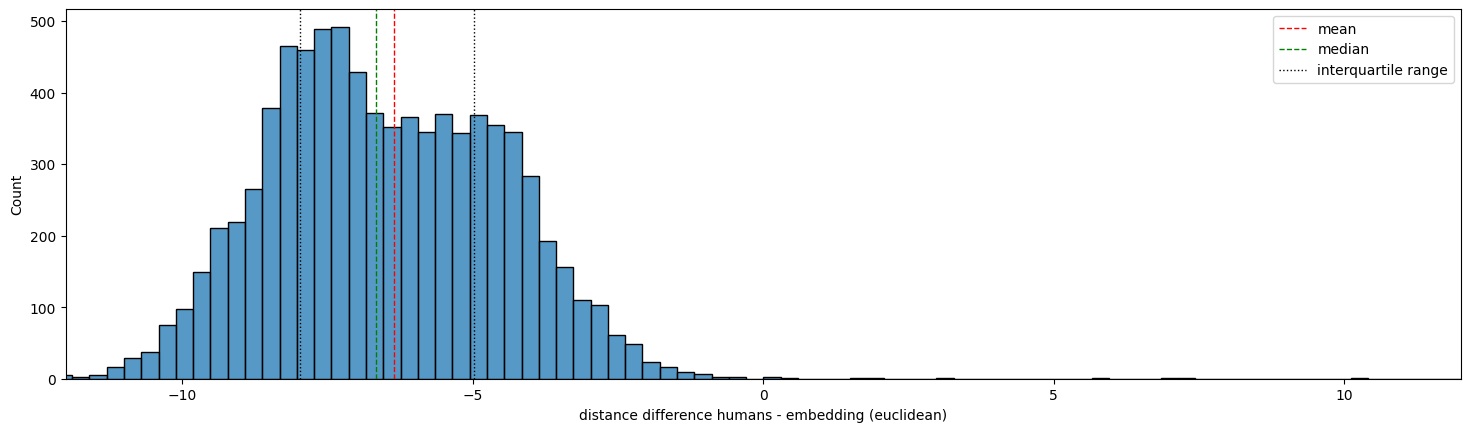

In [118]:
plt.figure().set_figwidth(18)
plt.xlim(-12,12)
sns.histplot(distance_differences_humans_euclidean)
# make the mean, median visible
plt.axvline(distance_differences_humans_euclidean.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(distance_differences_humans_euclidean.median(), color='green', linestyle='dashed', linewidth=1)
# show the 25th and 75th percentile
plt.axvline(distance_differences_humans_euclidean.quantile(0.25), color='black', linestyle='dotted', linewidth=1)
plt.axvline(distance_differences_humans_euclidean.quantile(0.75), color='black', linestyle='dotted', linewidth=1)
plt.legend(['mean', 'median', 'interquartile range'])
plt.xlabel('distance difference humans - embedding (euclidean)')

In [119]:
distance_differences_humans_euclidean.describe()

count    8106.000000
mean       -6.359402
std         3.242770
min       -13.373773
25%        -7.975845
50%        -6.661519
75%        -4.980761
max        59.167579
dtype: float64